Nainstalujeme potrebne knihovny

In [1]:
!!pip install beautifulsoup4
!!pip install tqdm
!!pip install pandas
!!pip install matplotlib

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns
import requests
import re
from tqdm import tqdm
from bs4 import BeautifulSoup
from matplotlib.pyplot import figure
import pandas as pd

from mpl_toolkits.mplot3d import Axes3D


In [2]:
brand_model_1= {'brand': 'skoda', 'model': 'fabia'}
brand_model_2= {'brand': 'ford', 'model': 'focus'}

Dale staci projet funkci, ktera vytahne data o aute z webu www.autoesa.cz

In [3]:
# funkce ktera vytahne potrebnou informaci z karticky s autem
def extract_price_and_title(car):
    car_title = car.find("span", class_="car-title").text
    car_price_dirty = car.find("div", class_="car_item__price_block text-red").find("span", class_="price").text
    car_price = re.sub("[^0-9]", '', car_price_dirty)
    car_year = car.find("div", class_ = "car_item__icon icon_year").text
    car_power = car.find("div", class_ = "car_item__icon icon_power").text
    car_fuel = car.find("div", class_ = "car_item__icon icon_fuel").text
    car_range = car.find("div", class_ = "car_item__icon icon_range").text
    return {
        "title": car_title,
        "price": int(car_price),
        "year": car_year,
        "power": car_power,
        "fuel": car_fuel,
        "range": car_range
    }

# funkce, ktera projde stranky zvolene znacky a modelu, a extrahuje potrebne informace
def databrand (brand, model):
    final=[]
    url = 'https://www.autoesa.cz/'
    # vypocitani poctu stranek
    brand_all = f"{url}/{brand}/{model}?stranka=1"
    response = requests.get(brand_all).text
    soup = BeautifulSoup(response, 'html.parser')
    num_pg_str = soup.find("div", class_="pagination").find("li", class_="dots dots-last").find("a", class_="ajax").text
    # pocet stranek
    num_pg = int(re.sub("[^0-9]", '', num_pg_str))
    # rada 1 az str_int
    page_range= [i for i in range(1,num_pg+1)]
    for i in tqdm(page_range):
        brand_url = f"{url}/{brand}/{model}?stranka={i}"
        page_html = requests.get(brand_url).text
        soup1 = BeautifulSoup(page_html, 'html.parser')
        cars_list = soup1.find_all("a", class_="car_item")
        final+=map(extract_price_and_title, cars_list)
    return final

Ulozeni nasbiranych dat (brand='zde napis znacku auta', model='zde napis model auta')

In [4]:
#promenna pro data znacky skoda fabia
data_auto_1= databrand(brand=brand_model_1['brand'], model=brand_model_1['model'])
#promenna pro data znacky ford focus
data_auto_2= databrand(brand=brand_model_2['brand'], model=brand_model_2['model'])

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:16<00:00,  2.02s/it]


Grafy

In [5]:
#1znacka: vytahne y promenne final separatni listy pro kazdy parametr zvlast
def lists_for_graph (data_brand):
    price_lst=[]
    name_lst=[]
    year_lst=[]
    power_lst=[]
    fuel_lst=[]
    range_lst=[]
    for item in data_brand:
        price_lst.append(item['price'])
        name_lst.append(item['title'])
        year_lst.append(int(item['year']))
        power_lst.append(int(re.sub("[^0-9]", '', item['power'])))
        fuel_lst.append(item['fuel'])
        range_lst.append(int(re.sub("[^0-9]", '', item['range'])))
    return price_lst, name_lst, year_lst, power_lst, fuel_lst, range_lst

#znacka1

price_lst_1, name_lst_1, year_lst_1, power_lst_1, fuel_lst_1, range_lst_1 = lists_for_graph(data_auto_1)

#znacka2

price_lst_2, name_lst_2, year_lst_2, power_lst_2, fuel_lst_2, range_lst_2 = lists_for_graph(data_auto_2)


In [6]:

##########################################GRAFY##############################################


#najde min, max a prumernou cenu aut vyhledavane znacky&modelu
min_max_avg_label=['Maximální cena', 'Minimální cena', 'Průměrná cena']

def max_min_avg_data (data_brand):
    max_price = max(item['price'] for item in data_brand)
    min_price = min(item['price'] for item in data_brand)
    avg_price = float(sum(item['price'] for item in data_brand)) / len(data_brand)
    #pridame do jednoho listu max, min a avg ceny aut konkretni znacky
    min_max_avg_list=[]
    min_max_avg_list.append(max_price)
    min_max_avg_list.append(min_price)
    min_max_avg_list.append(round(avg_price))
    return min_max_avg_list 

#znacka1
aggregated_data1=max_min_avg_data (data_auto_1)

#znacka2
aggregated_data2=max_min_avg_data (data_auto_2)



<Figure size 800x400 with 0 Axes>

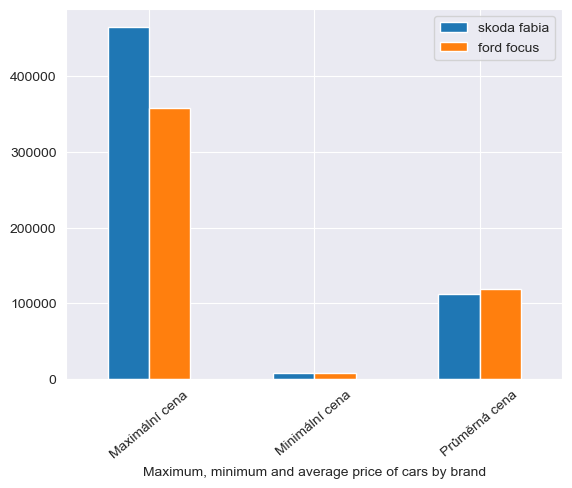

In [7]:

#vytvorime parametry pro osu x a y
# x_label = min_max_avg_label
# y_num= [agregated_data1, aggregated_data2]

label1 = brand_model_1['brand']+' '+brand_model_1['model']
label2 = brand_model_2['brand']+' '+brand_model_2['model']

df = pd.DataFrame(
    {
        "Maximum, minimum and average price of cars by brand": min_max_avg_label,
        label1: aggregated_data1,
        label2: aggregated_data2
    }
)

#velikost, barvy grafu atp
figure(num=None, figsize=(10,5), dpi=80, facecolor='w', edgecolor='r')

# #pridavam nazev Grafu a nazvy X a Y ose
# plt.title("Maximum, minimum and average price of cars by brand")
# # plt.xlabel("Parameter type")
# plt.ylabel("Price")

#vztisk bodoveho grafu
df.plot.bar(x='Maximum, minimum and average price of cars by brand', y = [label1, label2], rot = 40)

plt.show()

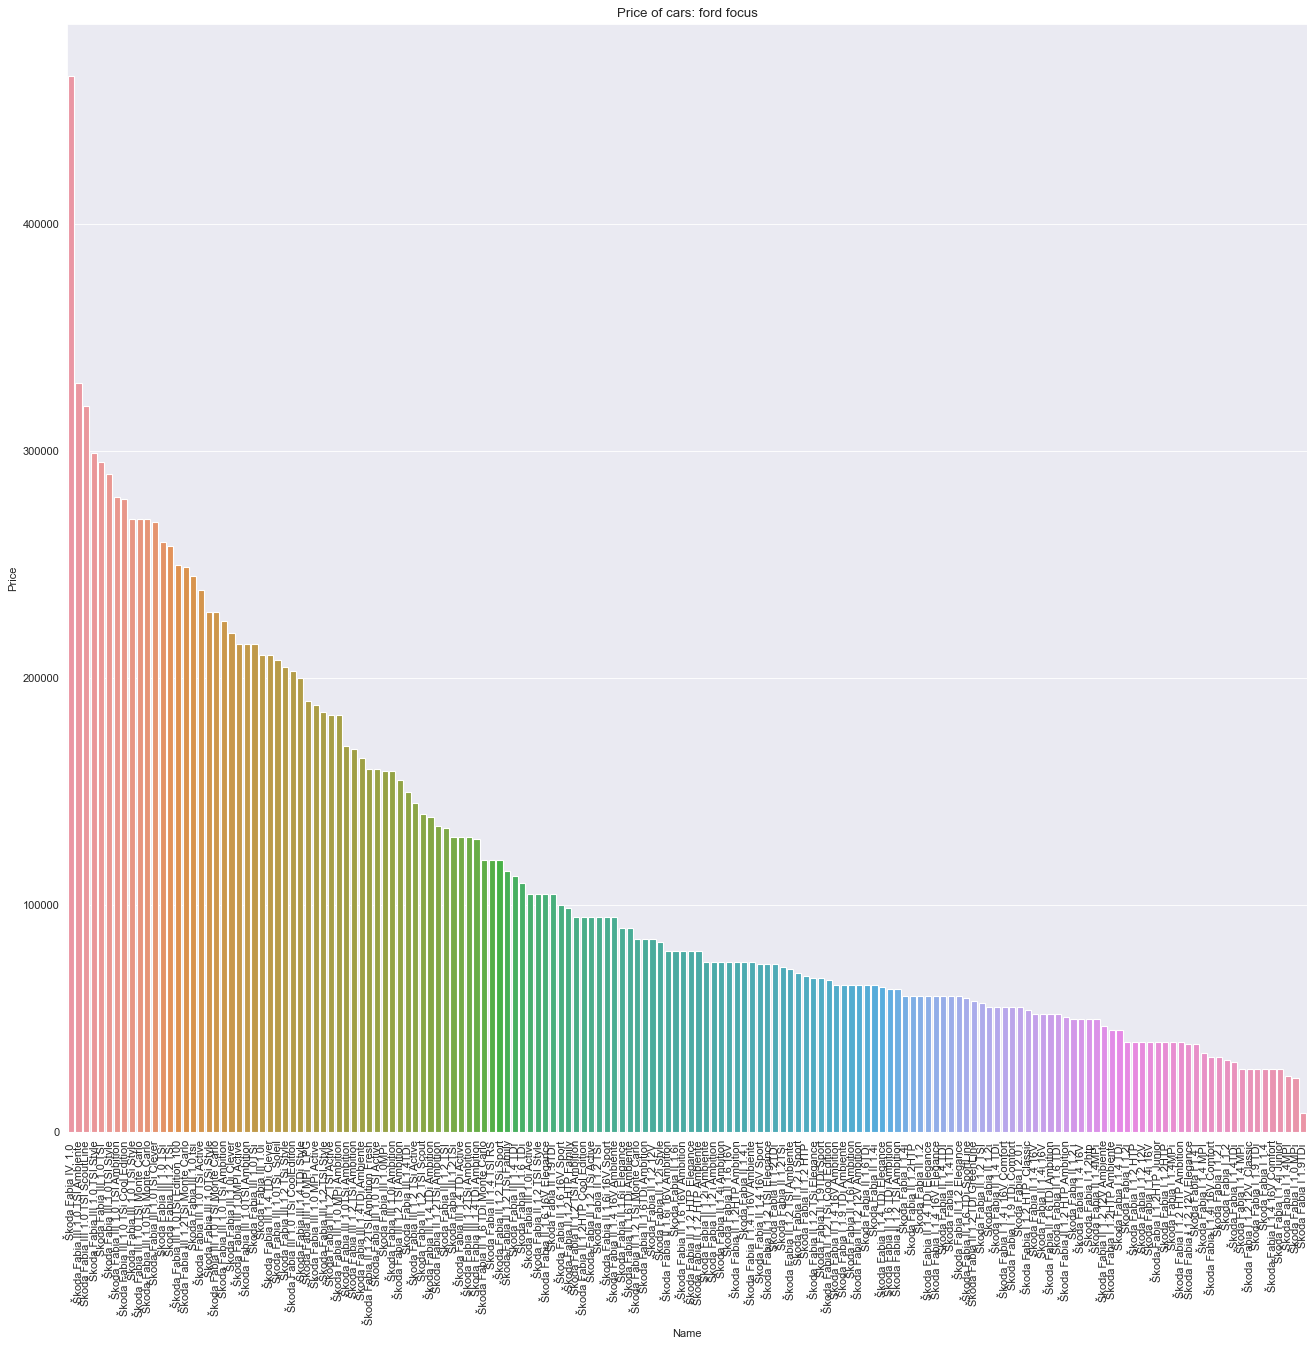

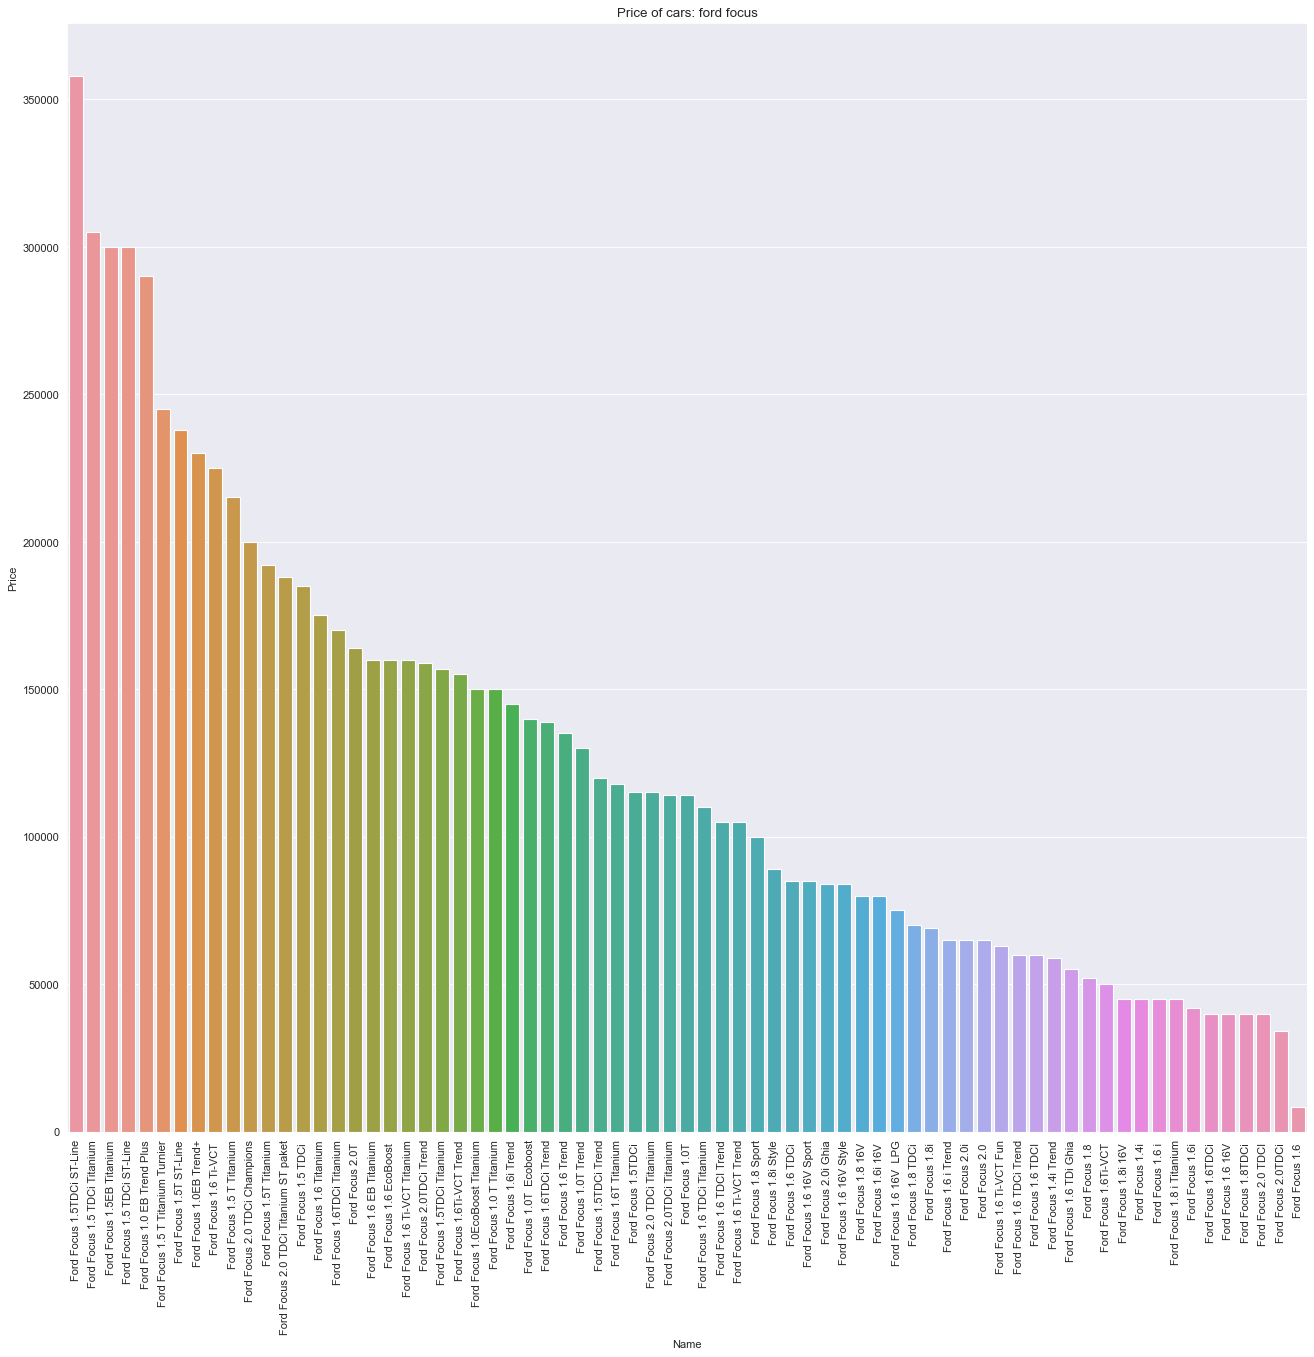

In [8]:
############################sloupcovy graf cen aut od nejdrazsiho################

# sparovani jmen aut a jejich cen pro nasledne serazeni
dic_name_price_1 = dict(zip(name_lst_1, price_lst_1))
dic_name_price_2 = dict(zip(name_lst_2, price_lst_2))

#seradime auta dle ceny od nejvyssi
sorted_dic_name_price_1 = sorted(dic_name_price_1.items(), key=lambda x:x[1], reverse=True)
sorted_dic_name_price_2 = sorted(dic_name_price_2.items(), key=lambda x:x[1], reverse=True)

#prevedeme to do formatu slovniku
converted_dict_1 = dict(sorted_dic_name_price_1)
converted_dict_2 = dict(sorted_dic_name_price_2)

# auto 1: vytvorime parametry pro osu x a y
keys_1 = list(converted_dict_1.keys())
vals_1= list(converted_dict_1.values())

# auto 2: vytvorime parametry pro osu x a y
keys_2 = list(converted_dict_2.keys())
vals_2= list(converted_dict_2.values())

### vykresleni grafu ###

# auto 1

figure(num=None, figsize=(20,18), dpi=80, facecolor='w', edgecolor='r')
sns.barplot(x=keys_1, y = vals_1).set(title="Price of cars: " + label2, xlabel='Name', ylabel='Price')
plt.xticks(rotation = 90)
plt.show()

# auto 2

figure(num=None, figsize=(20,18), dpi=80, facecolor='w', edgecolor='r')
sns.barplot(x=keys_2, y = vals_2).set(title="Price of cars: " + label2, xlabel='Name', ylabel='Price')
plt.xticks(rotation = 90)
plt.show()

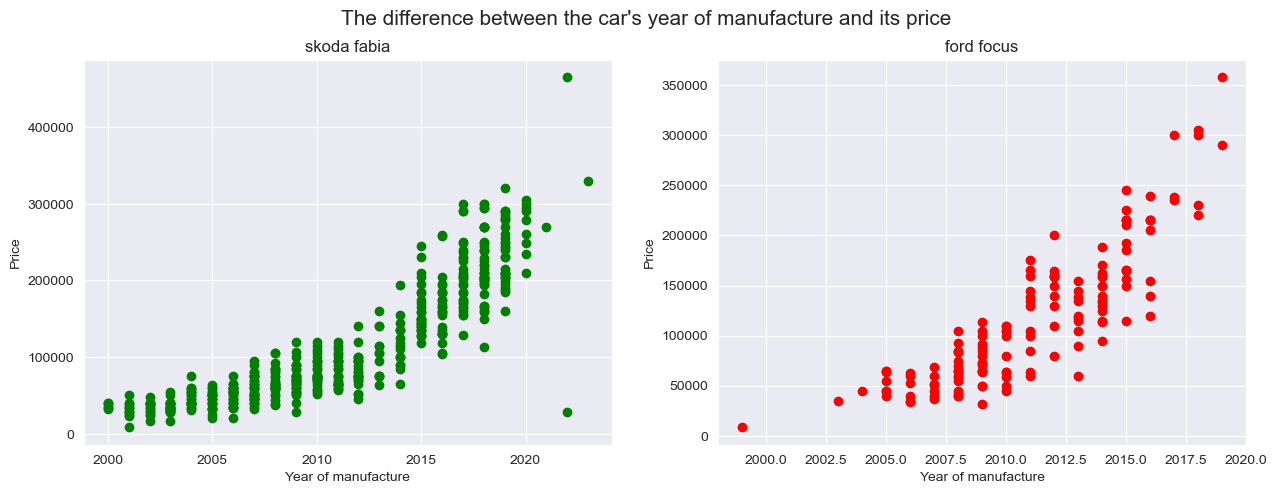

In [9]:
############################bodovy graf ceny aut vs rok vyroby################

# auto 1: vytvorime parametry pro osu x a y
x_year_1= year_lst_1
y_year_1= price_lst_1

# auto 2: vytvorime parametry pro osu x a y
x_year_2= year_lst_2
y_year_2= price_lst_2

### vykresleni grafu ###

figure, axis = plt.subplots(1, 2)
figure.suptitle("The difference between the car's year of manufacture and its price", fontsize=15)
figure.set_figheight(5)
figure.set_figwidth(15)

# auto 1
axis[0].scatter(x_year_1, y_year_1, c='g')
axis[0].set_title(label1)
axis[0].set_xlabel("Year of manufacture")
axis[0].set_ylabel("Price")

# auto 2
axis[1].scatter(x_year_2, y_year_2, c='r')
axis[1].set_title(label2)
axis[1].set_xlabel("Year of manufacture")
axis[1].set_ylabel("Price")


plt.show()

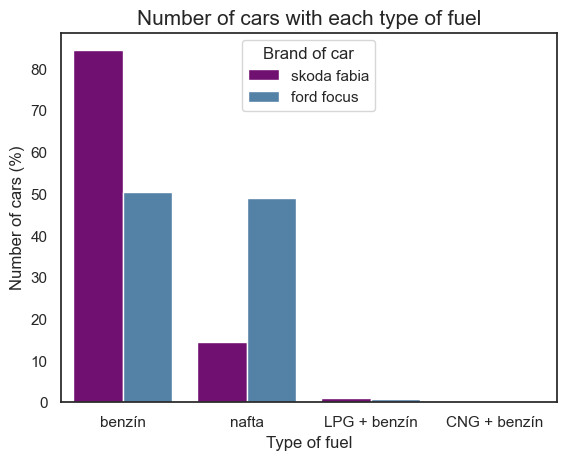

In [10]:
############################sloupcovy graf pocet aut s kazdym typem paliva################

# soucet aut s kazdym typem paliva
# auto 1
fuel_auto_1 = {i:(fuel_lst_1.count(i)/len(fuel_lst_1))*100 for i in fuel_lst_1}
# fuel_auto_1 = [i / len(fuel_lst_1) for i in fuel_auto_1.]
# auto 2
fuel_auto_2 = {i:(fuel_lst_2.count(i)/len(fuel_lst_2))*100 for i in fuel_lst_2}

# seradime parametry slovniku dle od nejvyssiho poctu
# auto 1
sorted_fuel_auto_1 = sorted(fuel_auto_1.items(), key=lambda x:x[1], reverse=True)
# auto 2
sorted_fuel_auto_2 = sorted(fuel_auto_2.items(), key=lambda x:x[1], reverse=True)

# prevedeme to do formatu slovniku
# auto 1
converted_fuel_auto_1 = dict(sorted_fuel_auto_1)
# auto 2
converted_fuel_auto_2 = dict(sorted_fuel_auto_2)


# auto 1: vytvorime parametry pro osu x a y
x_fuel_1 = list(converted_fuel_auto_1.keys())
y_fuel_1= list(converted_fuel_auto_1.values())
z_fuel_1=[label1] * len(y_fuel_1)

# auto 2: vytvorime parametry pro osu x a y
x_fuel_2 = list(converted_fuel_auto_2.keys())
y_fuel_2= list(converted_fuel_auto_2.values())
z_fuel_2=[label2] * len(y_fuel_2)

# vytvareni dataframu pro zobrazeni dat
df_fuel = pd.DataFrame (
    {
        'Type of fuel': list(converted_fuel_auto_1.keys()) + list(converted_fuel_auto_2.keys()),
        'Number of cars': list(converted_fuel_auto_1.values()) + list(converted_fuel_auto_2.values()),
        'Brand of car': z_fuel_1 + z_fuel_2
    }
)

### vykresleni grafu ###

sns.set(style='white')
sns.barplot(x='Type of fuel', y='Number of cars', hue='Brand of car', data=df_fuel, palette=['purple', 'steelblue'])
plt.title('Number of cars with each type of fuel', fontsize=15)
plt.xlabel('Type of fuel')
plt.ylabel('Number of cars (%)')

plt.show()

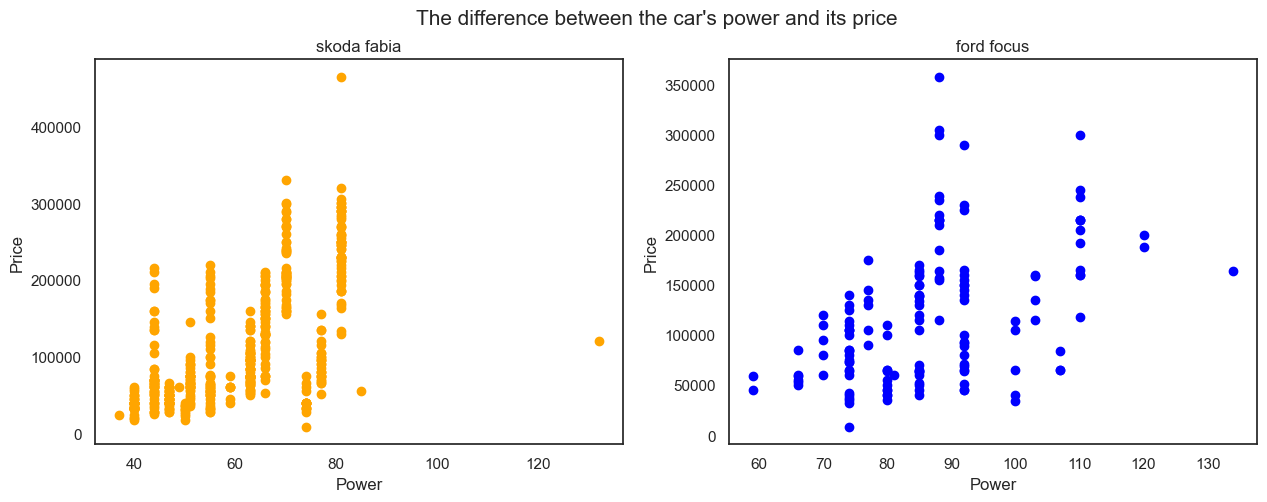

In [11]:
############################bodovy graf ceny aut vs vykon################
# auto 1: vytvorime parametry pro osu x a y
x_power_1 = power_lst_1
y_price_1 = price_lst_1

# auto 2: vytvorime parametry pro osu x a y
x_power_2 = power_lst_2
y_price_2 = price_lst_2


### vykresleni grafu ###

figure, axis = plt.subplots(1, 2)
figure.suptitle("The difference between the car's power and its price", fontsize=15)
figure.set_figheight(5)
figure.set_figwidth(15)

# auto 1
axis[0].scatter(x_power_1, y_price_1, c='orange')
axis[0].set_title(label1)
axis[0].set_xlabel("Power")
axis[0].set_ylabel("Price")

# auto 2
axis[1].scatter(x_power_2, y_price_2, c='blue')
axis[1].set_title(label2)
axis[1].set_xlabel("Power")
axis[1].set_ylabel("Price")


plt.show()


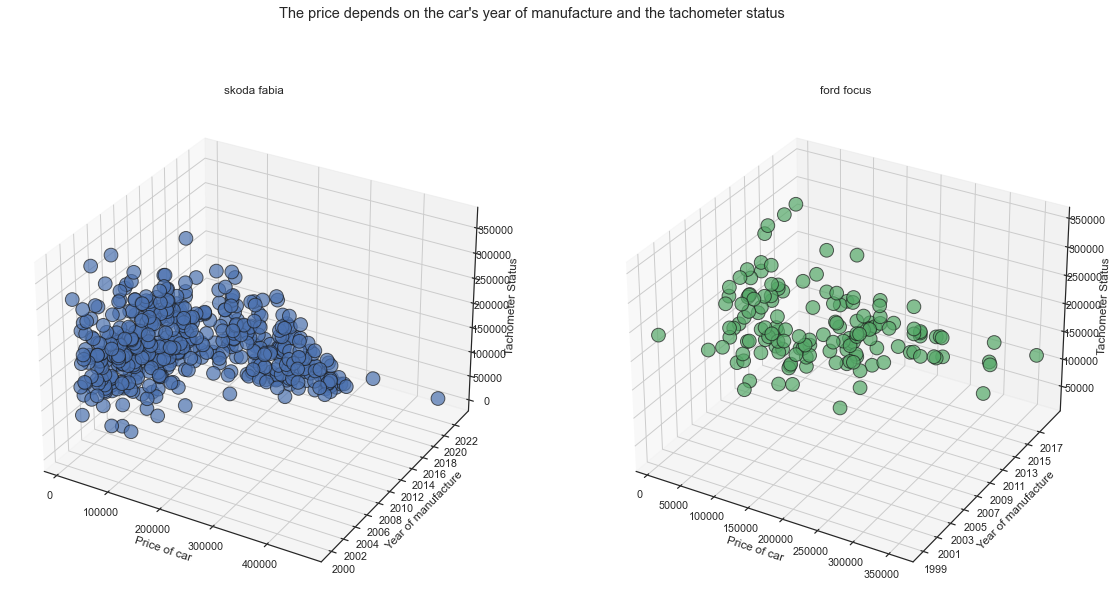

In [26]:
############################3D graf pocet aut s kazdym typem paliva################

# auto 1: vytvorime parametry pro osu x, y a z
x_3d_auto1 = price_lst_1
y_3d_auto1 = year_lst_1
z_3d_auto1 = range_lst_1


# x_3d_auto1, y_3d_auto1, z_3d_auto1 = np.meshgrid(np.arange(len(price_lst_1)), np.arange(len(year_lst_1)), np.arange(len(range_lst_1)))

# auto 2: vytvorime parametry pro osu x, y a z
x_3d_auto2 = price_lst_2
y_3d_auto2 = year_lst_2
z_3d_auto2 = range_lst_2

### vykresleni grafu ###

fig = plt.figure(dpi=70)
ax = fig.add_subplot(1, 2, 1, projection='3d')
fig.suptitle("The price depends on the car's year of manufacture and the tachometer status", fontsize=15)
fig.set_figheight(10)
fig.set_figwidth(20)

# auto 1
ax.scatter(x_3d_auto1, y_3d_auto1, z_3d_auto1,
           linewidths=1, alpha=.7,
           edgecolor='k',
           s = 200, c='b')
ax.set_title(label1)
ax.set_xlabel('Price of car')
ax.set_ylabel('Year of manufacture')
ax.set_zlabel('Tachometer Status')
ax.set_yticks(range(min(y_3d_auto1), max(y_3d_auto1), 2))

# auto 2

ax = fig.add_subplot(1, 2, 2, projection='3d')


ax.scatter(x_3d_auto2, y_3d_auto2, z_3d_auto2,
           linewidths=1, alpha=.7,
           edgecolor='k',
           s = 200, c='g')
ax.set_title(label2)
ax.set_xlabel('Price of car')
ax.set_ylabel('Year of manufacture')
ax.set_zlabel('Tachometer Status')
ax.set_yticks(range(min(y_3d_auto2), max(y_3d_auto2), 2))

plt.show()
